In [ ]:
#|default_exp tmp

# Cristopher Thomas 94.9% 5 epochs

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [ ]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
class Dropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training: return x
        dist = distributions.binomial.Binomial(tensor(1.0).to(x.device), probs=1-self.p)
        return x * dist.sample(x.size()) * 1/(1-self.p)

In [ ]:
#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [ ]:
from typing import Iterator
from torch.utils.data import DataLoader, WeightedRandomSampler

class TopLossesCallback(Callback):
  epoch_preds = []
  epoch_targets = []
  
  @torch.no_grad()
  def _calculate_top_losses(self):
    preds = torch.cat(self.epoch_preds, dim=0)
    targets = torch.cat(self.epoch_targets, dim=0)
    losses = F.cross_entropy(preds, targets, reduce=False)
    return torch.topk(losses, preds.shape[0]).indices

  def after_batch(self, learn):
    if not learn.model.training:
      return
    self.epoch_preds.append(learn.preds)
    self.epoch_targets.append(learn.batch[1])

  def before_epoch(self, learn):
    self.epoch_preds = []
    self.epoch_targets = []

  def after_epoch(self, learn):
    if not learn.model.training:
      return
    learn.dls.train.sampler.top_losses = self._calculate_top_losses()

# tweaked from tommyc's version
# Before certain epoch drop a % of the training dataset with the lowest losses.
# Replace them with the the same % of the training dataset with the highest losses.
# This gives the model two opportunities to train on the most challenging images.
class CustomTrainingSampler(WeightedRandomSampler):
  def __init__(self, *args, **kwargs):
    WeightedRandomSampler.__init__(self, *args, **kwargs)
    self.data_indexes_for_epoch = []
    self.top_losses = []
    self.epoch = -1
    self.n = {
        0: 0,
        1: 0.21,
        2: 0.42,
        3: 0.21,
        4: 0
    }

  def __iter__(self) -> Iterator[int]:
      self.epoch += 1
      rand_tensor = torch.randperm(self.num_samples, generator=self.generator).tolist()
      n = int(self.n[self.epoch] * self.num_samples)

      if n != 0:
        # TODO: Cleanup the code below
        inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()
        self.data_indexes_for_epoch = torch.tensor(self.data_indexes_for_epoch).cpu()
        self.data_indexes_for_epoch[self.top_losses[-n:].cpu()] = self.data_indexes_for_epoch[inverted_losses_for_epochs]
        self.data_indexes_for_epoch = self.data_indexes_for_epoch[rand_tensor]
        self.data_indexes_for_epoch = self.data_indexes_for_epoch.tolist()
      else:
        self.data_indexes_for_epoch = rand_tensor

      yield from self.data_indexes_for_epoch


class CustomDataLoader:
    def __init__(self, *dls): 
      self.train,self.valid = dls[:2]

    def get_sampler(num_samples, mode="train"):
      if mode != "train":
        return None
      return CustomTrainingSampler(weights=[1 for _ in range(num_samples)], num_samples=num_samples)

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
      return cls(*[DataLoader(ds, batch_size, sampler=cls.get_sampler(len(ds), mode), collate_fn=collate_dict(ds), **kwargs) for mode, ds in dd.items()])

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = CustomDataLoader.from_dd(tds, bs, num_workers=0)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def get_model9(act=nn.ReLU, nfs=(32,288,288,288,288,288), norm=nn.BatchNorm2d):#,256
    layers = [ResBlock(1, 32, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
from torchvision import transforms

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [ ]:
#| export
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_preds,self.all_targs = [],[]
    def after_batch(self, learn):
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))
    def after_fit(self, learn): self.all_preds,self.all_targs = torch.cat(self.all_preds),torch.cat(self.all_targs)

In [ ]:
#| export
@fc.patch
def capture_preds(self: Learner, cbs=None):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=[cp]+fc.L(cbs))
    return cp.all_preds,cp.all_targs

In [ ]:
# tweaked from rohitgeo's version
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(Mish))
cbs = [DeviceCB(), metrics, TopLossesCallback(), ProgressCB(plot=True), astats]
act_gr = Mish
iw = partial(init_weights, leaky=0.0003)
#0.0003 from https://github.com/digantamisra98/Mish/issues/37

In [ ]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
    def _f(hook, mod, inp, outp):
        nonlocal res,tot
        nparms = sum(o.numel() for o in mod.parameters())
        tot += nparms
        res += f'|{type(mod)}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, train=False, cbs=SingleBatchCB())
    print("Tot params: ", tot)
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

accuracy,loss,epoch,train
0.832,0.636,0,train
0.828,0.547,0,eval
0.824,0.501,1,train
0.854,0.397,1,eval
0.763,0.613,2,train
0.920,0.236,2,eval
0.776,0.559,3,train
0.926,0.216,3,eval
0.960,0.146,4,train
0.943,0.181,4,eval


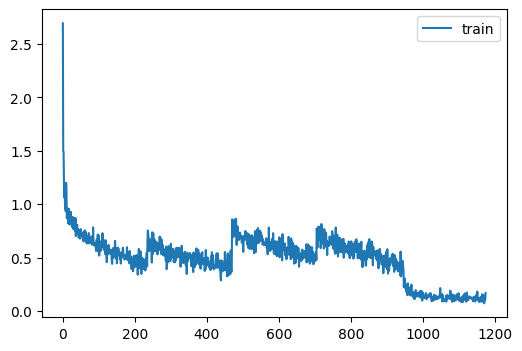

/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/tmp/ipykernel_1400/3750922393.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()


Fit 5 in: 566.43s, setup: 0.00s, 110.41 ± 6.25s per epoch, 0.36 ± 0.06s per batch


In [ ]:
set_seed(1)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

In [ ]:
ap1, at = learn.capture_preds()

accuracy,loss,epoch,train
0.943,0.181,0,eval


In [ ]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

accuracy,loss,epoch,train
0.944,0.175,0,eval


In [ ]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
round((ap==at).float().mean().item(), 4)

0.9451